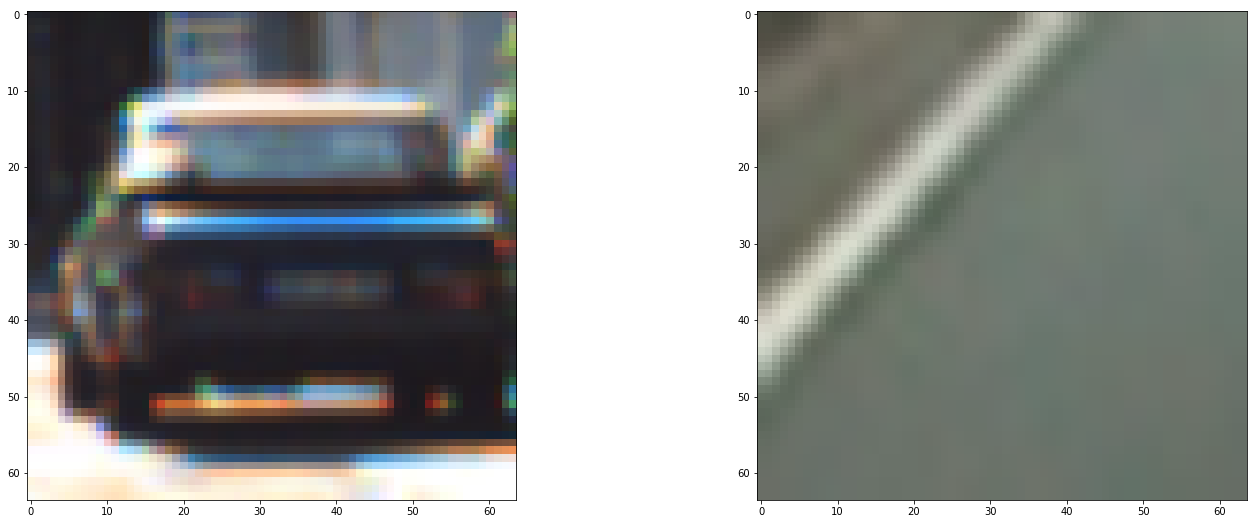

In [83]:
# demo HOG feature 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

car_example = mpimg.imread('vehicles/KITTI_extracted/1.png')
notcar_example = mpimg.imread('non-vehicles/GTI/image12.png')
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(car_example)
ax2.imshow(notcar_example)



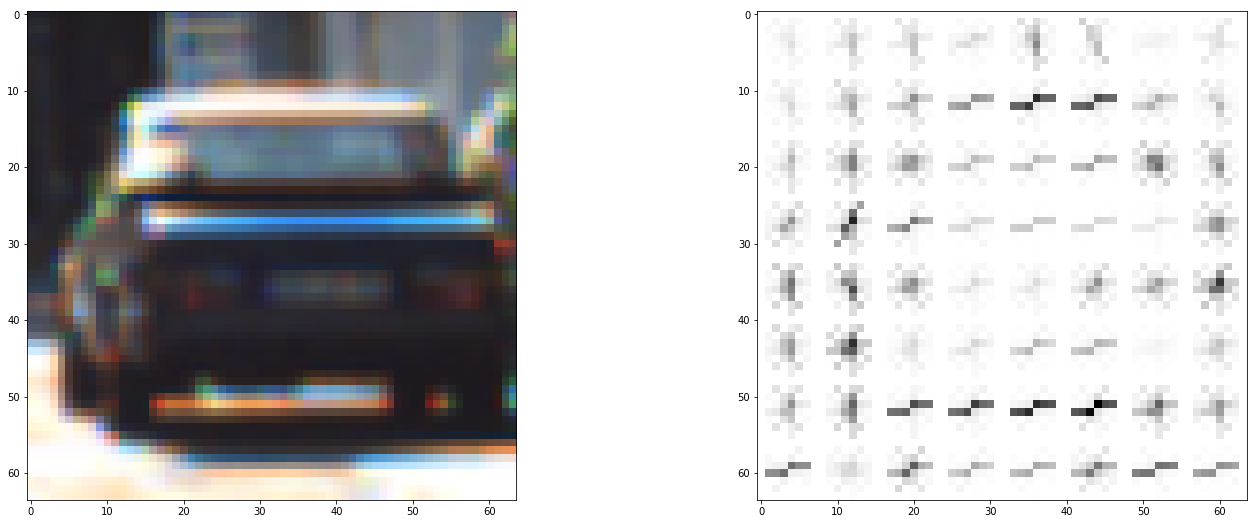

In [87]:
# HOG feature
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
feature_image = cv2.cvtColor(car_example, cv2.COLOR_RGB2HSV)
features_car, hog_image_car = get_hog_features(feature_image[:,:,0], orient =9 , pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(car_example)
ax2.imshow(hog_image_car, cmap = 'Greys')


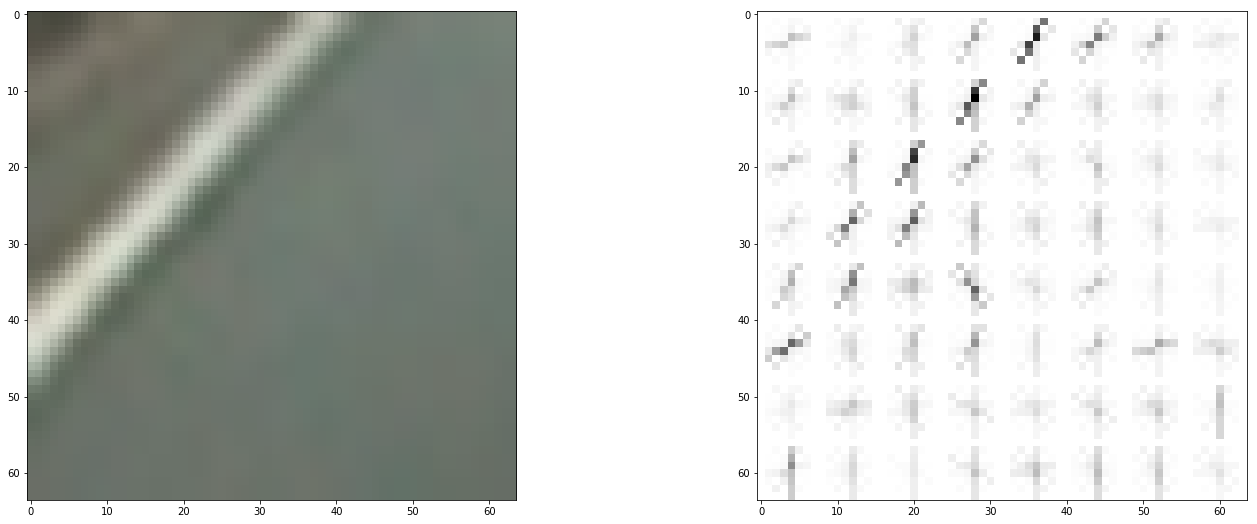

In [90]:
feature_image = cv2.cvtColor(notcar_example, cv2.COLOR_RGB2HSV)
features_nocar, hog_image_nocar = get_hog_features(feature_image[:,:,0], orient =9 , pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(notcar_example)
ax2.imshow(hog_image_nocar, cmap = 'Greys')

In [17]:
# Train the classifier on the training images

# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#hog feature function 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#single image feature extraction
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    

    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                #hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    return np.concatenate(img_features)

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)  #0-1 scale
        feature_img = single_img_features(image, color_space = cspace, spatial_size=spatial_size, 
                                          hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                          cell_per_block=cell_per_block, hog_channel=hog_channel)
        # Append the new feature vector to the features list
        features.append(feature_img)
    # Return list of feature vectors
    return features

cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')


# Extract features 
#tunable parameters
cspace = 'HSV'
#channel = (0,1,2,'ALL')
hog_channel = 'ALL'
spatial_size = (32,32)
histbin = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
car_features = extract_features(cars, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,hog_channel=hog_channel)


# Build labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial_size,
    'and', histbin,'histogram bins',cspace,'Color space', 
      hog_channel, 'channel for HOG feature')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#clf = GridSearchCV(svc, parameters)
#clf.fit(X_train, y_train)
#print(clf.best_params_)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')








/Users/gycelect/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using spatial binning of: (32, 32) and 32 histogram bins HSV Color space ALL channel for HOG feature
Feature vector length: 8460
4.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9916
My SVC predicts:  [0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 1.]
For these 100 labels:  [0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 1.]
0.00391 Seconds to predict 100 labels with SVC


In [79]:
# save classifer
import pickle
svc_dict = {}
svc_dict['svc'] = svc
svc_dict['scaler'] = X_scaler
svc_dict['orient'] = orient
svc_dict['pix_per_cell'] = pix_per_cell
svc_dict['cell_per_block'] = cell_per_block
svc_dict['spatial_size'] = spatial_size
svc_dict['hist_bins'] = hist_bins
svc_dict['hog_channel'] = hog_channel
svc_dict['cspace'] = cspace

with open('svc_pickle.p','wb') as f:
    pickle.dump(svc_dict, f)
f.close()
 



In [52]:
# Define function to find vehicle in images 

# Use feature extraction used for training and fitted svc model to predict 
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            # Use the traine svc to predict 
            test_prediction = svc.predict(test_features)
            #print(sum(test_prediction))
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #print((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))      
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#draw boxes on the image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [80]:
#load the classifier
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


In [81]:
print(orient)
print(pix_per_cell)
print(cell_per_block)
print(spatial_size)
print(hist_bins)

9
8
2
(32, 32)
32


(720, 1280, 3)
1 cars found


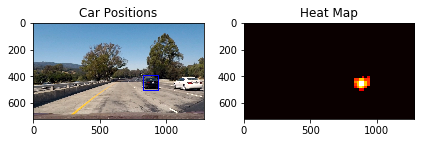

In [82]:
# Test on test image
from scipy.ndimage.measurements import label
image = mpimg.imread('test_images/test1.jpg')
#image = image/255.
print(image.shape)
ystart = 300
ystop = 656
scale = 1.2
#parameters to be load from pickle
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins =32
#use parameter from training 
box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,box_list)
heatmap = apply_threshold(heatmap, 2)


# Visualize the heatmap when displaying    
heatmap = np.clip(heatmap, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
print(labels[1], 'cars found')
#show the heatmap result 
%matplotlib inline
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


(720, 1280, 3)
10 cars found


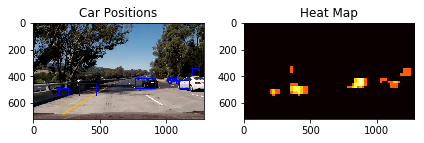

In [71]:
# Test on another image
# Test on test image
from scipy.ndimage.measurements import label
image = mpimg.imread('test_images/test5.jpg')
#image = image/255.
print(image.shape)
#use parameter from training 
box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,box_list)
heatmap = apply_threshold(heatmap, 2)


# Visualize the heatmap when displaying    
heatmap = np.clip(heatmap, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
print(labels[1], 'cars found')
#show the heatmap result 
%matplotlib inline
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [ ]:
# tracking pipeline 


In [72]:
# Test on video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def vehicle_track(image):
    #image = image/255.
    ystart = 300
    ystop = 656
    scale = 1.2
    #parameters to be load from pickle
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32,32)
    hist_bins =32
    #print(image.shape)
    #use parameter from training 
    box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap,box_list)
    heatmap = apply_threshold(heatmap, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img 

In [75]:

test_output = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(vehicle_track) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:28<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 28.2 s, sys: 866 ms, total: 29.1 s
Wall time: 29.9 s


In [76]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [77]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("project_video.mp4")
project_clip = clip2.fl_image(vehicle_track) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [16:29<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 16min, sys: 27.7 s, total: 16min 28s
Wall time: 16min 30s


In [78]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))